<a href="https://colab.research.google.com/github/harimshin/data-science-portfolio/blob/main/machine_learning_binary_classification_with_SMOTE_prediction_model_for_the_severity_of_car_accidents.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Machine Learning Model to Predict the Severity of the Car Accidents**

# **I. Data Preparation**

In [1]:
# install pyspark
%%bash
pip install pyspark

# get data file
data_file=US_Accidents_Dec21_updated.csv
if [[ ! -f ./${data_file} ]]; then
   # download the data file from github and save it in this colab environment instance
   wget https://media.githubusercontent.com/media/harimshin/public_dataset/main/${data_file} &>/dev/null
fi

# Original source of dataset: https://www.kaggle.com/datasets/sobhanmoosavi/us-accidents

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.3/317.3 MB 3.1 MB/s eta 0:00:00
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for pyspark: filename=pyspark-3.5.3-py2.py3-none-any.whl size=317840625 sha256=b1ba1c463bdf87af370fb60fe96bfd6ff994ac1d74ebfd611accffc43c96f1bc
  Stored in directory: /root/.cache/pip/wheels/1b/3a/92/28b93e2fbfdbb07509ca4d6f50c5e407f48dce4ddbda69a4ab
Successfully built pyspark


In [2]:
# create spark context
from pyspark.sql import SparkSession
spark = SparkSession.builder.config("spark.driver.memory", "32g").getOrCreate()

# **II. Data Collection & Cleaning**

In [3]:
# import car accidents dataset into a pyspark dataframe
df = spark.read.option("header",True).csv("US_Accidents_Dec21_updated.csv")

from pyspark.sql.functions import count

# print the shape of the dataframe
print("Number of rows in the dataframe: ", df.count())
print("Number of columns in the dataframe: ", len(df.columns))

Number of rows in the dataframe:  2845342
Number of columns in the dataframe:  47


In [4]:
# drop the columns not necessary for the analysis
drop_cols = ('End_Time', 'Start_Lat', 'Start_Lng', 'End_Lat', 'End_Lng', 'City', 'County', 'Airport_Code', 'Description', 'Number', 'Street', 'Zipcode', 'Country', 'Weather_Timestamp', 'Weather_Condition')
df2 = df.drop(*drop_cols)

# delete rows with any null/NA column
car_acc = df2.na.drop()
print("Number of rows in the dataframe: ", car_acc.count())
print("Number of columns in the dataframe: ", len(car_acc.columns))

Number of rows in the dataframe:  2212394
Number of columns in the dataframe:  32


In [5]:
from pyspark.sql.functions import col, when, date_format, to_date, hour
from pyspark.sql.types import FloatType, BooleanType, StringType

# convert the data types into the new data type which can be more appropriate for the analysis
# group severity degree 1 & 2 into 0 (non-severe) and 3 & 4 into 1 (severe)
car_acc2 = car_acc.\
  withColumn("Severity", when(car_acc.Severity < 3, 0).when(car_acc.Severity >= 3, 1)).\
  withColumn("Day_of_Week", date_format(to_date("Start_Time"), "E")).\
  withColumn("Hour", hour("Start_Time").cast(StringType())).\
  withColumn("Start_Time", to_date("Start_Time")).\
  withColumn("Distance(mi)", col("Distance(mi)").cast(FloatType())).\
  withColumn("Temperature(F)", col("Temperature(F)").cast(FloatType())).\
  withColumn("Wind_Chill(F)", col("Wind_Chill(F)").cast(FloatType())).\
  withColumn("Humidity(%)", col("Humidity(%)").cast(FloatType())).\
  withColumn("Pressure(in)", col("Pressure(in)").cast(FloatType())).\
  withColumn("Visibility(mi)", col("Visibility(mi)").cast(FloatType())).\
  withColumn("Wind_Direction", when(car_acc.Wind_Direction == 'North', "N").when(car_acc.Wind_Direction == "South", "S").\
             when(car_acc.Wind_Direction == "East", "E").when(car_acc.Wind_Direction == "West", "W"). when(car_acc.Wind_Direction ==  "Variable", "VAR").otherwise(car_acc.Wind_Direction)).\
  withColumn("Wind_Speed(mph)", col("Wind_Speed(mph)").cast(FloatType())).\
  withColumn("Precipitation(in)", col("Precipitation(in)").cast(FloatType()))

In [6]:
car_acc2 = car_acc2.drop('Start_Time')

In [7]:
# print schema of newly transformed variables
car_acc2.printSchema()

root
 |-- ID: string (nullable = true)
 |-- Severity: integer (nullable = true)
 |-- Distance(mi): float (nullable = true)
 |-- Side: string (nullable = true)
 |-- State: string (nullable = true)
 |-- Timezone: string (nullable = true)
 |-- Temperature(F): float (nullable = true)
 |-- Wind_Chill(F): float (nullable = true)
 |-- Humidity(%): float (nullable = true)
 |-- Pressure(in): float (nullable = true)
 |-- Visibility(mi): float (nullable = true)
 |-- Wind_Direction: string (nullable = true)
 |-- Wind_Speed(mph): float (nullable = true)
 |-- Precipitation(in): float (nullable = true)
 |-- Amenity: string (nullable = true)
 |-- Bump: string (nullable = true)
 |-- Crossing: string (nullable = true)
 |-- Give_Way: string (nullable = true)
 |-- Junction: string (nullable = true)
 |-- No_Exit: string (nullable = true)
 |-- Railway: string (nullable = true)
 |-- Roundabout: string (nullable = true)
 |-- Station: string (nullable = true)
 |-- Stop: string (nullable = true)
 |-- Traffic_Ca

In [8]:
car_acc2.show(10)

+----+--------+------------+----+-----+----------+--------------+-------------+-----------+------------+--------------+--------------+---------------+-----------------+-------+-----+--------+--------+--------+-------+-------+----------+-------+-----+---------------+--------------+------------+--------------+--------------+-----------------+---------------------+-----------+----+
|  ID|Severity|Distance(mi)|Side|State|  Timezone|Temperature(F)|Wind_Chill(F)|Humidity(%)|Pressure(in)|Visibility(mi)|Wind_Direction|Wind_Speed(mph)|Precipitation(in)|Amenity| Bump|Crossing|Give_Way|Junction|No_Exit|Railway|Roundabout|Station| Stop|Traffic_Calming|Traffic_Signal|Turning_Loop|Sunrise_Sunset|Civil_Twilight|Nautical_Twilight|Astronomical_Twilight|Day_of_Week|Hour|
+----+--------+------------+----+-----+----------+--------------+-------------+-----------+------------+--------------+--------------+---------------+-----------------+-------+-----+--------+--------+--------+-------+-------+----------+

# **III. Data Exploration & Insights**

**1. The relationship between the state and the car accidents severity**

In [9]:
pip install chart_studio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.4/64.4 kB 6.1 MB/s eta 0:00:00


In [10]:
from random import sample

car_acc2_pd = car_acc2.toPandas()

In [11]:
import pandas as pd
from chart_studio import plotly
import plotly.graph_objects as go

from pyspark.sql.functions import round

# summarize the count of the severity by state
acc_state = car_acc2[['Severity', 'State']]
acc_state_crosstab = acc_state.crosstab('State', 'Severity').orderBy('State_Severity')
acc_state_crosstab_prob = acc_state_crosstab.withColumn("prob_0", round(col("0") / (col("0") + col("1")), 2)).\
                                              withColumn("prob_1", round(col("1") / (col("0") + col("1")), 2)).\
                                              withColumnRenamed('State_Severity', 'State')
# convert the spark df to pandas df
acc_state_crosstab_prob_pd = acc_state_crosstab_prob.toPandas()

# visualize the probability that an accident is severe in the state
fig = go.Figure(
    data=go.Choropleth(
        locations = acc_state_crosstab_prob_pd['State'],
        z = acc_state_crosstab_prob_pd['prob_1'].astype(float),
        locationmode = 'USA-states',
        colorscale = 'Reds',
        colorbar_title = "Probability",
))

fig.update_layout(
    title_text = 'Severe Car Accident Probability by State',
    geo_scope='usa',
)

fig.show()

With the modified severity variable, I calculated the probability of an accident to be ‘severe’, and plotted the probability on the US state map.
We can see that in Colorado, Wisconsin, and Illinois, almost 50% percent of car accidents are severe.  


**2. Number of car accidents by severity group**
In our original data, we can verify that accidents with severity degree 2 is most common. Thus, I decided to convert the target variable into dummy variable indicating if the accident is severe or not. I categorized the accident with severity degree less or equal to 2 as 0 which means “not severe accidents”, and the accidents with severity degree greater than 2 as 1 which means “severe accidents".

In [12]:
from pyspark.sql.functions import  asc

# distribution of the target variable(the severity of the car accidents)
car_acc2.groupBy("Severity").count().orderBy(col('Severity').asc()).show()

+--------+-------+
|Severity|  count|
+--------+-------+
|       0|2085485|
|       1| 126909|
+--------+-------+



We can see that roughly 89% of data are categorized as 1 or 2, only 11% are categorized as 3 or 4

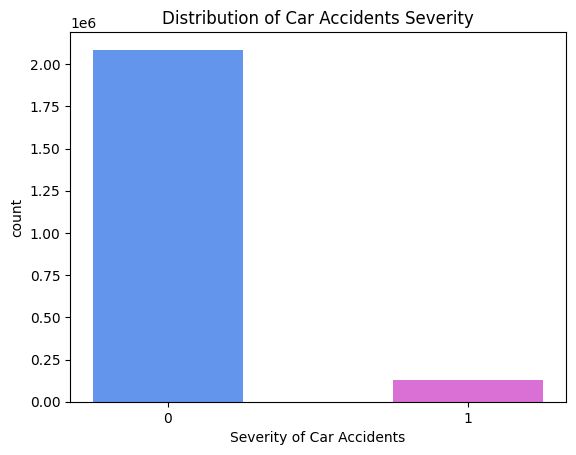

In [13]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

# visualize the the count of severity group
severity_dist = car_acc2.groupby('Severity').count().orderBy(col('Severity').asc()).toPandas()
plt.bar(severity_dist['Severity'], severity_dist['count'], width = 0.5, color = ['cornflowerblue', 'orchid'])
plt.xticks([0,1])
plt.xlabel('Severity of Car Accidents')
plt.ylabel('count')
plt.title('Distribution of Car Accidents Severity')
plt.show()

We can observe only 11% of our data points are in the minority class (Severity = 1). This imbalanced data prevent the model to effectively learn the decision boundary. To solve this problem, I use Synthetic Minority Oversampling Technique (SMOTE), which is the most prevantly used approach to synthesize new examples from the minority class. I will use the new balanced dataset in the later section.

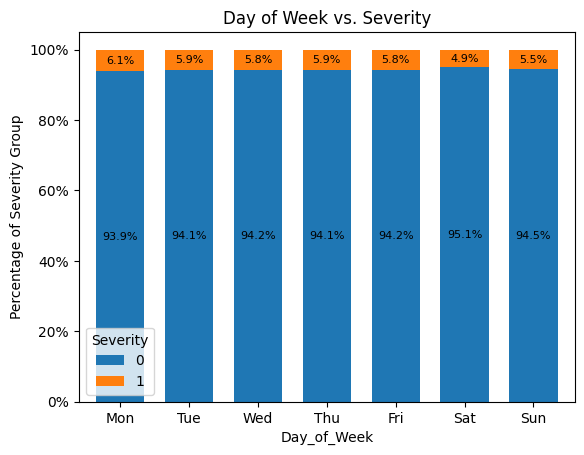

In [14]:
dow = pd.crosstab(car_acc2_pd['Day_of_Week'], car_acc2_pd['Severity']).apply(lambda r: r/r.sum(), axis=1)
dow_order = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
dow = dow.reindex(dow_order, axis=0)

dow_bar = dow.plot(kind="bar", stacked=True, rot=0, width = 0.7, ylabel = 'Day_of_Week')
for bars in dow_bar.containers:
      heights = [b.get_height() for b in bars]
      labels = [f'{h * 100:.1f}%' if h > 0.001 else '' for h in heights]
      dow_bar.bar_label(bars, labels=labels, label_type='center', fontsize = 8)
dow_bar.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: '{:.0%}'.format(y)))
dow_bar.set_ylabel('Percentage of Severity Group')
dow_bar.set_title("Day of Week vs. Severity")
plt.show()

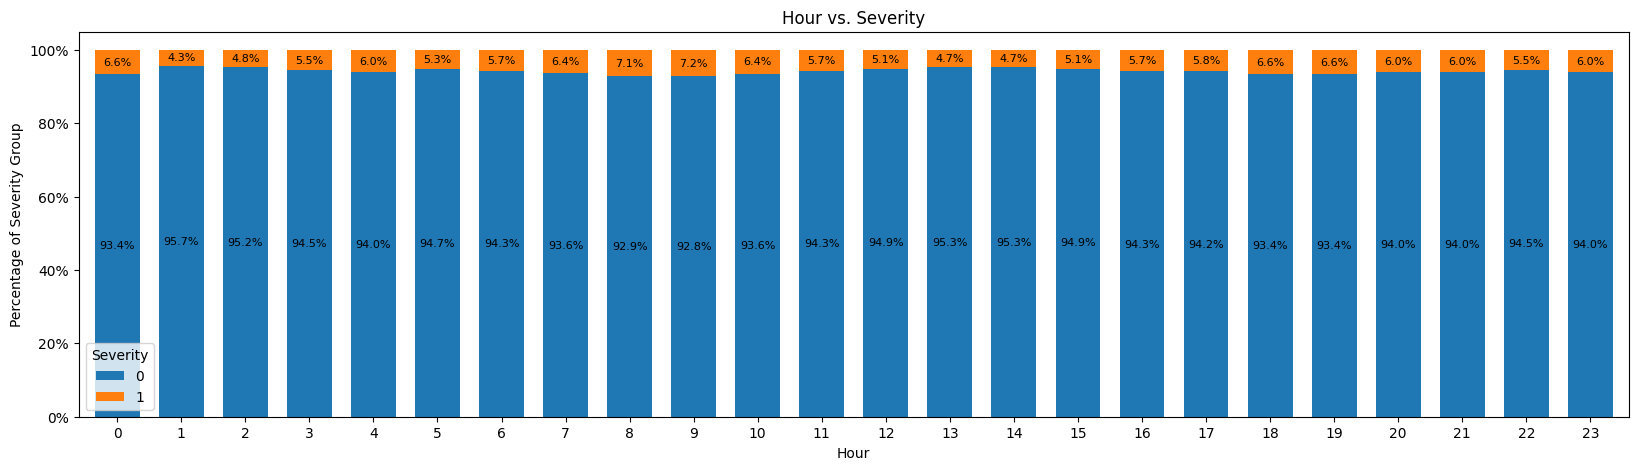

In [15]:
hour = pd.crosstab(car_acc2_pd['Hour'], car_acc2_pd['Severity']).apply(lambda r: r/r.sum(), axis=1)
hour_order = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23']
hour = hour.reindex(hour_order, axis=0)
hour_bar = hour.plot(kind="bar", stacked=True, rot=0, width = 0.7, ylabel = 'Hour', figsize=(20, 5))
for bars in hour_bar.containers:
      heights = [b.get_height() for b in bars]
      labels = [f'{h * 100:.1f}%' if h > 0.001 else '' for h in heights]
      hour_bar.bar_label(bars, labels=labels, label_type='center', fontsize = 8)
hour_bar.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: '{:.0%}'.format(y)))
hour_bar.set_ylabel('Percentage of Severity Group')
hour_bar.set_title("Hour vs. Severity")
plt.show()

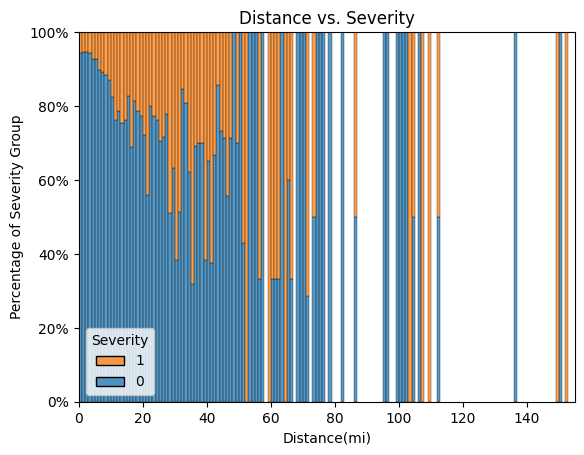

In [16]:
import seaborn as sns
import warnings

# visualize the relationship between distance and severity level
warnings.filterwarnings("ignore", category=FutureWarning, module="seaborn")
ax = sns.histplot(data=car_acc2_pd, x='Distance(mi)', hue='Severity', multiple='fill',
             bins=np.arange(0, max(car_acc2_pd['Distance(mi)']), 1), hue_order = [1, 0], palette = ['#ff7f0e', '#1f77b4'])
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: '{:.0%}'.format(y)))
plt.ylabel('Count')
plt.xlabel('Distance(mi)')
plt.ylabel('Percentage of Severity Group')
plt.title('Distance vs. Severity')
plt.show()

We can see that if the distance between start point and end point of the accident, the severity of it increases. However, distance can be measured only after the accident happens, I did not include this for the model.

Text(0.5, 1.0, 'Side vs. Severity')

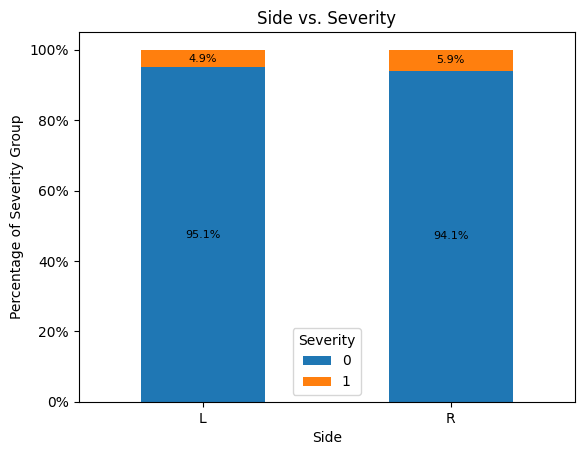

In [17]:
# visualize the relationship between side and severity level
side = pd.crosstab(car_acc2_pd['Side'], car_acc2_pd['Severity']).apply(lambda r: r/r.sum(), axis=1)
side_bar = side.plot(kind="bar", stacked=True, rot=0, width = 0.5, ylabel = 'Side')
for bars in side_bar.containers:
      heights = [b.get_height() for b in bars]
      labels = [f'{h * 100:.1f}%' if h > 0.001 else '' for h in heights]
      side_bar.bar_label(bars, labels=labels, label_type='center', fontsize = 8)
side_bar.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: '{:.0%}'.format(y)))
side_bar.set_ylabel('Percentage of Severity Group')
side_bar.set_title("Side vs. Severity")

We can verify that the car accidents in the right lane is more severe than those in the left lane.

Text(0.5, 1.0, 'Timezone vs. Severity')

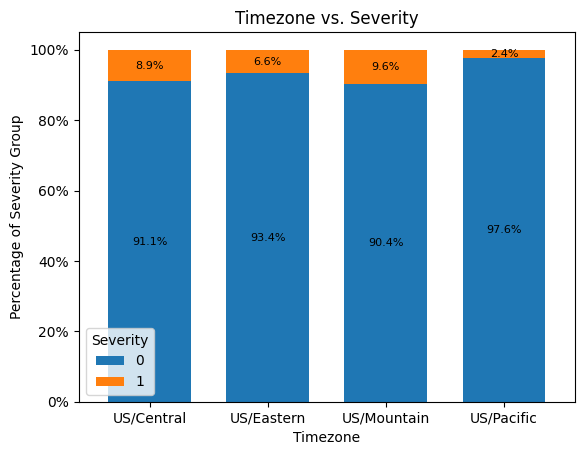

In [18]:
# visualize the relationship between timezone and severity level
timezone = pd.crosstab(car_acc2_pd['Timezone'], car_acc2_pd['Severity']).apply(lambda r: r/r.sum(), axis=1)
timezone_bar = timezone.plot(kind="bar", stacked=True, rot=0, width = 0.7, ylabel = 'Timezone')
for bars in timezone_bar.containers:
    heights = [b.get_height() for b in bars]
    labels = [f'{h * 100:.1f}%' if h > 0.001 else '' for h in heights]
    timezone_bar.bar_label(bars, labels=labels, label_type='center', fontsize = 8)
timezone_bar.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: '{:.0%}'.format(y)))
timezone_bar.set_ylabel('Percentage of Severity Group')
timezone_bar.set_title("Timezone vs. Severity")

We can verify that the car accidents in central or mountain time zone are more severe than those in eastern or pacific time zone.

**3-1. Weather-related features: correlation**

Text(0.5, 1.0, 'Weather Features Correlation Heatmap')

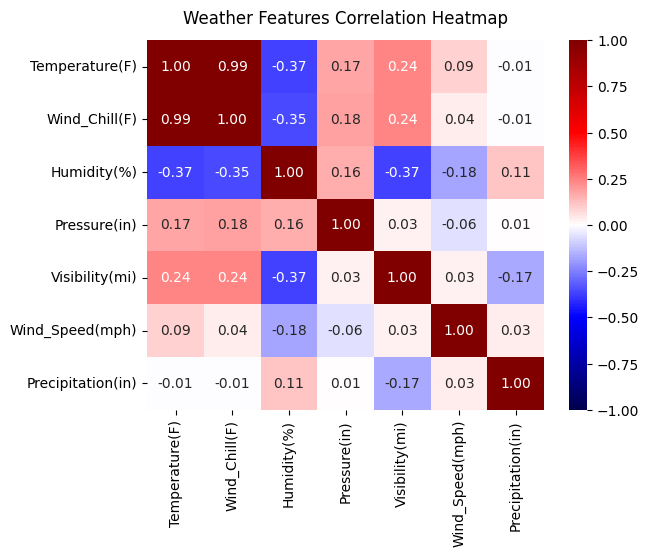

In [19]:
# visualize the correlation between weather-related features
weather_list=['Temperature(F)','Wind_Chill(F)','Humidity(%)','Pressure(in)', 'Visibility(mi)', 'Wind_Speed(mph)', 'Precipitation(in)']
weather_df = car_acc2_pd[weather_list]
weather_corr = sns.heatmap(weather_df.corr(), vmin=-1, vmax=1, annot=True, cmap="seismic", fmt=".2f")
weather_corr.set_title('Weather Features Correlation Heatmap', fontdict={'fontsize':12}, pad=12)

From the correlation heat map, we can see that temperature and wind_chill are highly correlated(0.99).

**3-2. Weather-related features: bar plots**

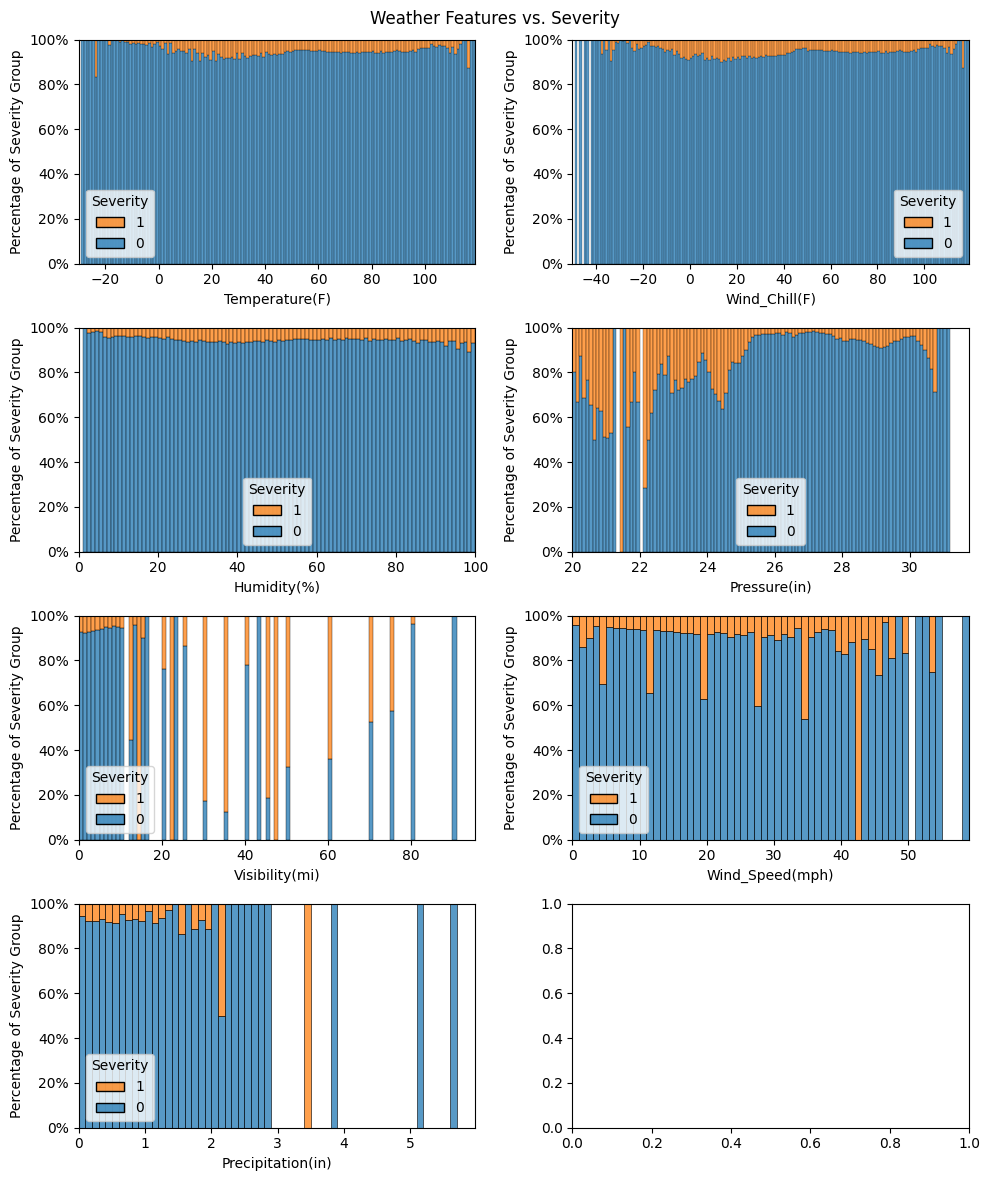

In [20]:
from matplotlib.ticker import PercentFormatter

# visualize the relationship between weather-related features and severity level
warnings.filterwarnings("ignore", category=FutureWarning, module="seaborn")

fig, axes = plt.subplots(4,2, figsize = (10, 12))

temp_hist = sns.histplot(
    data=car_acc2_pd, x='Temperature(F)', hue='Severity', multiple='fill', \
    bins=np.arange(-30, 120, 1), \
    hue_order = [1, 0], palette = ['#ff7f0e', '#1f77b4'], \
    ax = axes[0,0])
temp_hist.set_ylabel('Percentage of Severity Group')
temp_hist.yaxis.set_major_formatter(PercentFormatter(1))

wchill_hist = sns.histplot(
    data=car_acc2_pd, x='Wind_Chill(F)', hue='Severity', multiple='fill', \
    bins=np.arange(-50, 120, 1), \
    hue_order = [1, 0], palette = ['#ff7f0e', '#1f77b4'],\
    ax = axes[0,1])
wchill_hist.set_ylabel('Percentage of Severity Group')
wchill_hist.yaxis.set_major_formatter(PercentFormatter(1))

humid_hist = sns.histplot(
    data=car_acc2_pd, x='Humidity(%)', hue='Severity', multiple='fill', \
    bins = np.arange(0, 101, 1), \
    hue_order = [1, 0], palette = ['#ff7f0e', '#1f77b4'],\
    ax = axes[1,0])
humid_hist.set_ylabel('Percentage of Severity Group')
humid_hist.yaxis.set_major_formatter(PercentFormatter(1))

pressure_hist = sns.histplot(
    data=car_acc2_pd, x='Pressure(in)', hue='Severity', multiple='fill', \
    bins = np.arange(20, 32, 0.1), \
    hue_order = [1, 0], palette = ['#ff7f0e', '#1f77b4'],\
    ax = axes[1,1])
pressure_hist.set_ylabel('Percentage of Severity Group')
pressure_hist.yaxis.set_major_formatter(PercentFormatter(1))

vis_hist = sns.histplot(
    data=car_acc2_pd, x='Visibility(mi)', hue='Severity', multiple='fill', \
    hue_order = [1, 0], palette = ['#ff7f0e', '#1f77b4'],\
    bins = np.arange(0, 100, 1), \
    ax = axes[2,0])
vis_hist.set_ylabel('Percentage of Severity Group')
vis_hist.yaxis.set_major_formatter(PercentFormatter(1))

wspeed_hist = sns.histplot(
    data=car_acc2_pd, x='Wind_Speed(mph)', hue='Severity', multiple='fill', \
    hue_order = [1, 0], palette = ['#ff7f0e', '#1f77b4'],\
    bins = np.arange(0, 60, 1), \
    ax = axes[2,1])
wspeed_hist.set_ylabel('Percentage of Severity Group')
wspeed_hist.yaxis.set_major_formatter(PercentFormatter(1))

precip_hist = sns.histplot(
    data=car_acc2_pd, x='Precipitation(in)', hue='Severity', multiple='fill', \
    hue_order = [1, 0], palette = ['#ff7f0e', '#1f77b4'],\
    bins = np.arange(0, 10, 0.1), \
    ax = axes[3,0])
precip_hist.set_ylabel('Percentage of Severity Group')
precip_hist.yaxis.set_major_formatter(PercentFormatter(1))

fig.suptitle('Weather Features vs. Severity', fontsize=12)
plt.tight_layout()
plt.show()

The box plots from the weather-related features show that see the conditions of pressure and wind speed when a car accident happened can be good features to predict the severity of the car accidents.
Plots show that the car accidents in very low or very high temperature(wind chill) are more severe than others.
Also, we can find that low humidity, low pressure, and low visibility causes the car accidents to be severe.

Text(0.5, 1.0, 'Wind Direction vs. Severity')

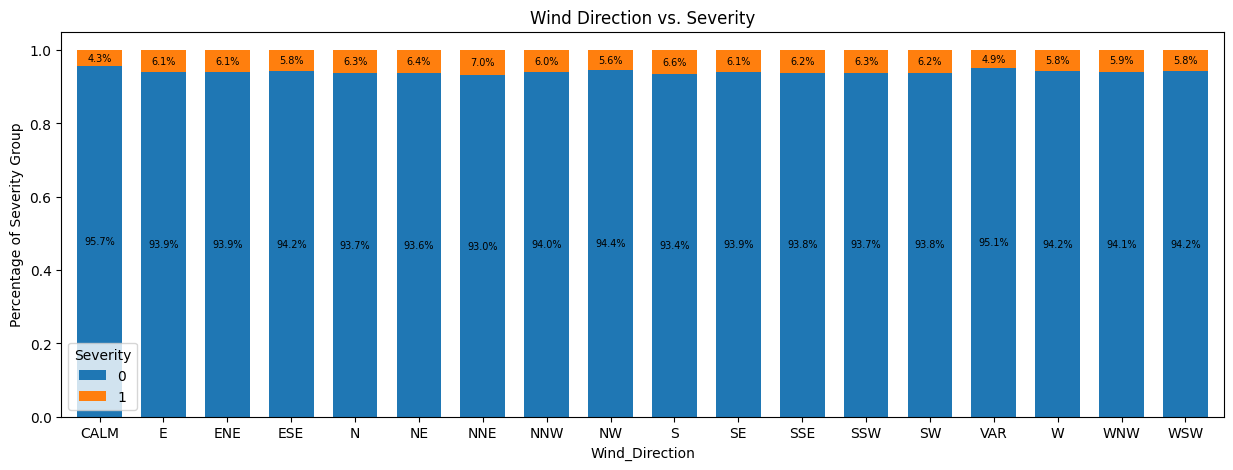

In [21]:
# visualize the relationship between wind direction and severity level
wind_dir = pd.crosstab(car_acc2_pd['Wind_Direction'], car_acc2_pd['Severity']).apply(lambda r: r/r.sum(), axis=1)
wind_dir_bar = wind_dir.plot(kind="bar", stacked=True, rot=0, width = 0.7, ylabel = 'Wind_Direction',figsize=(15, 5))
for bars in wind_dir_bar.containers:
      heights = [b.get_height() for b in bars]
      labels = [f'{h * 100:.1f}%' if h > 0.001 else '' for h in heights]
      wind_dir_bar.bar_label(bars, labels=labels, label_type='center', fontsize = 7)
wind_dir_bar.set_ylabel('Percentage of Severity Group')
wind_dir_bar.set_title("Wind Direction vs. Severity")

**4-1. Traffic-related features: correlation heatmap**


In [22]:
# create a list of features related to traffic
traffic_list = ['Amenity', 'Bump', 'Crossing', 'Give_Way', 'Junction', \
                'No_Exit', 'Railway', 'Roundabout', 'Station', 'Stop', \
                'Traffic_Calming', 'Traffic_Signal', 'Turning_Loop']

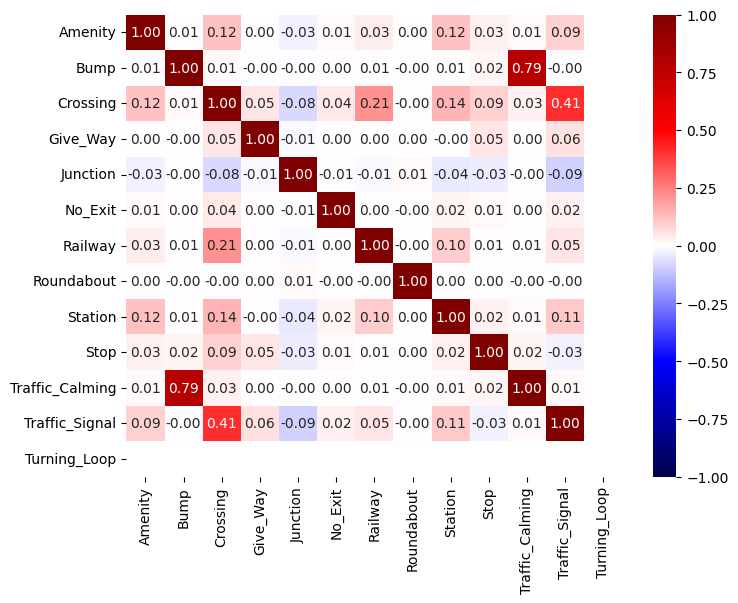

In [23]:
traffic_df = car_acc2_pd[traffic_list].astype('category')

for feature in traffic_list:
  traffic_df[feature] = traffic_df[feature].cat.rename_categories({'False' : 0, "True" : 1})

plt.figure(figsize=(8, 6))
traffic_corr = sns.heatmap(traffic_df.corr(), vmin=-1, vmax=1, annot=True, cmap="seismic", fmt=".2f")
weather_corr.set_title('Traffic Features Correlation Heatmap', fontdict={'fontsize':12}, pad=12)
plt.show()

We can verify that Bump and Traffic Calming, Crossing and Traffic Signal have high correlation.

**4-2. Traffic-related features: bar plots**

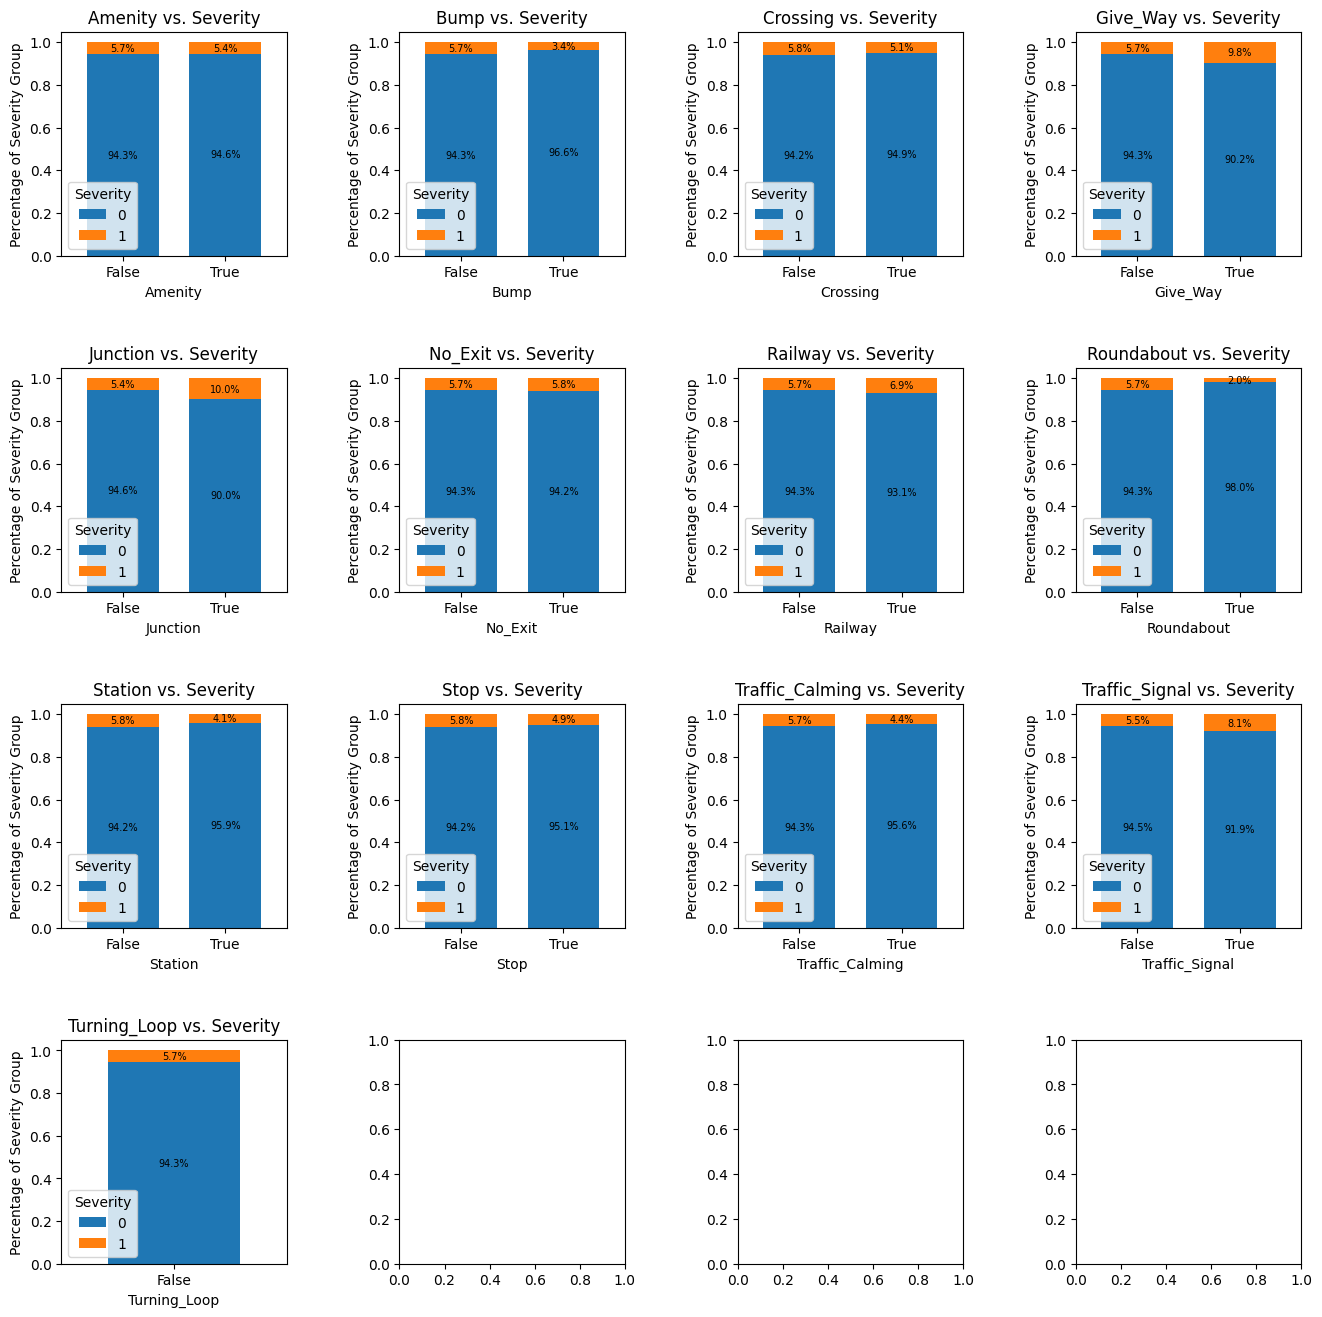

In [24]:
# visualize the relationship between traffic condition and severity level
fig, axes = plt.subplots(4, 4, figsize = (16, 16))
fig.subplots_adjust(hspace=0.5, wspace=0.5)
for i in range(len(traffic_list)):
  ct = pd.crosstab(car_acc2_pd[traffic_list[i]], car_acc2_pd['Severity']).apply(lambda r: r/r.sum(), axis=1)
  ct_bar = ct.plot(ax=axes[i//4, i%4], kind="bar", stacked=True, rot=0, width = 0.7, ylabel = traffic_list[i])

  for bars in ct_bar.containers:
      heights = [b.get_height() for b in bars]
      labels = [f'{h * 100:.1f}%' if h > 0.001 else '' for h in heights]
      ct_bar.bar_label(bars, labels=labels, label_type='center', fontsize = 7)

  ct_bar.set_ylabel('Percentage of Severity Group')
  ct_bar.set_title(traffic_list[i] + " vs. Severity")

The bar plots from the traffic-related features show that see whether there is a `Junction` or `Traffic_Signal` can be good features to predict the `Severity` of the car accidents.

In [25]:
traffic_list.remove("Turning_Loop")

In [26]:
print(traffic_list)

['Amenity', 'Bump', 'Crossing', 'Give_Way', 'Junction', 'No_Exit', 'Railway', 'Roundabout', 'Station', 'Stop', 'Traffic_Calming', 'Traffic_Signal']


**5-1. Sunlight-related features: correlation**

In [27]:
# create a list of features related to sunlight
sunlight_list = ['Sunrise_Sunset', 'Civil_Twilight', 'Nautical_Twilight', 'Astronomical_Twilight']

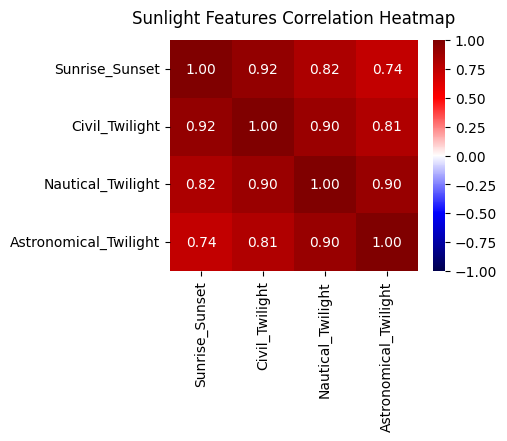

In [28]:
sunlight_df = car_acc2_pd[sunlight_list].astype('category')

for feature in sunlight_list:
  sunlight_df[feature] = sunlight_df[feature].cat.rename_categories({'Day' : 0, "Night" : 1})

plt.figure(figsize=(4, 3))
sunlight_corr = sns.heatmap(sunlight_df.corr(), vmin=-1, vmax=1, annot=True, cmap="seismic", fmt=".2f")
sunlight_corr.set_title('Sunlight Features Correlation Heatmap', fontdict={'fontsize':12}, pad=12)
plt.show()

We can verify the sunlight-related features are highly correlated (> 0.70)

**3-3. Sunlight-related features**

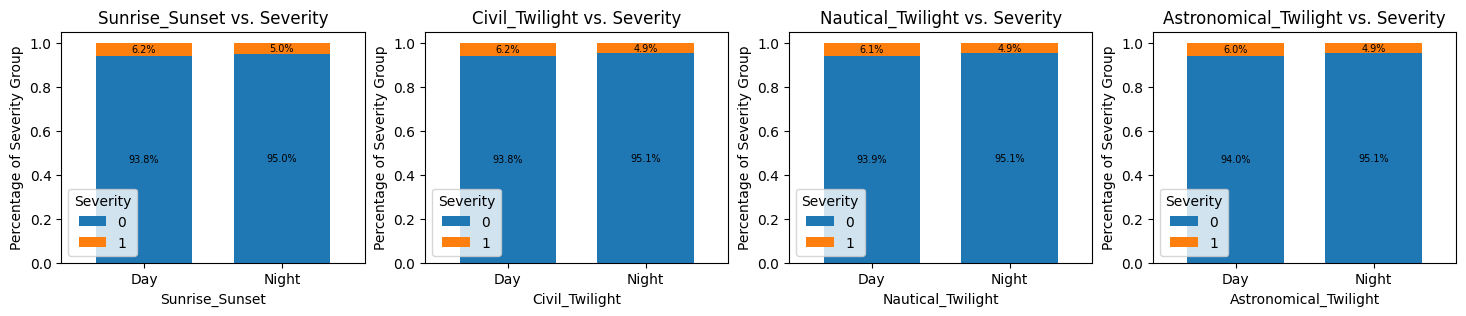

In [29]:
# visualize the relationship between sunlight condition and severity level
fig, axes = plt.subplots(1,4, figsize = (18,3))

for i in range(len(sunlight_list)):
 ct = pd.crosstab(car_acc2_pd[sunlight_list[i]], car_acc2_pd['Severity']).apply(lambda r: r/r.sum(), axis=1)
 ct_bar = ct.plot(ax=axes[i], kind = "bar", stacked = True, rot=0, width = 0.7, ylabel = 'Severity')

 for bars in ct_bar.containers:
  heights = [b.get_height() for b in bars]
  labels = [f'{h * 100:.1f}%' if h > 0.001 else '' for h in heights]
  ct_bar.bar_label(bars, labels=labels, label_type='center', fontsize = 7)

  ct_bar.set_ylabel('Percentage of Severity Group')
  ct_bar.set_title(sunlight_list[i] + " vs. Severity")

The bar plots from the sunlight-related features show that there not so much difference between two conditions, day and night, in predicting car accidents severity.

# **IV. Model Predictions**

For the binary classification task (Severity = 0 or 1), I used multiple models for the task such as logistic regression, SVM, random forest, and gradient boosting and compared their performance. Before running the models, I conducted Synthesized Minority Oversampling Technique (SMOTE) to deal with the issue of imbalance in our dataset.

**Synthetic Minority Oversampling Technique (SMOTE)**

In [30]:
# sample the large dataset (10%) to run the models with given resources
car_acc3 = car_acc2.sample(0.10)

In [31]:
# rename "Severity" variable to "label" for convenience in the further steps
imbalanced_df = car_acc3.withColumnRenamed("Severity", "label")

# split the data into training data and testing data (we don't need validation data because we are using crossvalidator)
imbalanced_training_df, test_df = imbalanced_df.randomSplit([0.7, 0.3])

# convert the spark df to pandas df
imbalanced_training_pd = imbalanced_training_df.toPandas()

# create the lists of categorical features for SMOTE
categorical_features = traffic_list + sunlight_list + ['Day_of_Week', 'Hour', 'Side', 'State', 'Timezone', 'Wind_Direction']

# convert the type of categorical features from object to category
for feature in categorical_features:
  imbalanced_training_pd[feature] = imbalanced_training_pd[feature].astype('category')

# separate features and labels
X_training_imbalanced = imbalanced_training_pd.drop(['ID', 'label', 'Turning_Loop'], axis=1)  # Features (excluding the label column)
y_training_imbalanced = imbalanced_training_pd['label']  # Label (target variable)

In [32]:
pip install imbalanced-learn

In [33]:
from imblearn.over_sampling import SMOTENC

# initialize the SMOTE object
smote_nc = SMOTENC(categorical_features = categorical_features, random_state = 42)
X_resampled, y_resampled = smote_nc.fit_resample(X_training_imbalanced, y_training_imbalanced)

# convert the resampled data to a spark df
resampled_final = pd.concat([y_resampled, X_resampled], axis = 1)
balanced_training_df = spark.createDataFrame(resampled_final)

**Create pipelie and set evaluator for models**

In [34]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.feature import VectorAssembler, StandardScaler, StringIndexer, OneHotEncoder
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml import Pipeline

In [35]:
numeric_features = weather_list

In [36]:
# vector assembler for numeric features
assembler_pre_scaler = VectorAssembler(
    inputCols = numeric_features,
    outputCol = "pre_scaler_numeric_features"
)

scaler = StandardScaler(
    inputCol = "pre_scaler_numeric_features",
    outputCol = "pre_assembled_scaled_numeric_features",
    withStd=True, withMean=True
)

assembler_numeric = VectorAssembler(
    inputCols = ["pre_assembled_scaled_numeric_features"],
    outputCol = "scaled_numeric_features"
)

indexers = [
    StringIndexer(inputCol=col, outputCol= f"{col}_index")
    for col in categorical_features
]
encoders = [
    OneHotEncoder(inputCol=f"{col}_index", outputCol=f"{col}_ohe")
    for col in categorical_features
]
assembler_categorical = VectorAssembler(
    inputCols = [f"{col}_ohe" for col in categorical_features],
    outputCol = "ohe_categorical_features"
)

# vector assembler for all features
assembler_all = VectorAssembler(
    inputCols= ["scaled_numeric_features"] + ["ohe_categorical_features"],
    outputCol="features"
)

In [37]:
# create an evaluator to get AUC of binaryclassification models
evaluator_auc = BinaryClassificationEvaluator(labelCol="label", metricName="areaUnderROC")

**Logistic regression with hyperparameter tuning**

In [38]:
from pyspark.ml.classification import LogisticRegression

# Initialize the logistic regression model
lr = LogisticRegression(featuresCol="features", labelCol = "label")

# Create a pipeline including the binaryclassification model
lr_pipeline = Pipeline(
    stages = indexers + encoders
    + [assembler_pre_scaler, scaler]
    + [assembler_numeric, assembler_categorical, assembler_all, lr]
)

# create a grid of parameters for hyperparameter tuning
lr_paramGrid = ParamGridBuilder() \
    .addGrid(lr.regParam, [0.01, 0.1, 1.0]) \
    .addGrid(lr.elasticNetParam, [0.0, 0.5, 1.0]) \
    .build()

# create a crossvalidator using the pipeline, parameter grid, evaluator set above
lr_crossval = CrossValidator(estimator = lr_pipeline,
                      estimatorParamMaps = lr_paramGrid,
                      evaluator = evaluator_auc,
                      numFolds = 5,
                      parallelism = 4)

# create a model by fitting the crossvalidator set above to the balanced training data
lr_model = lr_crossval.fit(balanced_training_df)

# derive the tuned hyperparameters
lr_bestModel = lr_model.bestModel.stages[-1]
print("Best Model Hyperparameters:")
print(" - regParam:", lr_bestModel._java_obj.getRegParam())
print(" - elasticNetParam:", lr_bestModel._java_obj.getElasticNetParam())

Best Model Hyperparameters:
 - regParam: 0.01
 - elasticNetParam: 0.0


**Support Vector Machines (SVM) with Hyperparameter Tuning**

In [39]:
from pyspark.ml.classification import LinearSVC

lsvc = LinearSVC(featuresCol="features", labelCol="label")

lsvc_pipeline = Pipeline(
    stages = indexers + encoders
    + [assembler_pre_scaler, scaler]
    + [assembler_numeric, assembler_categorical, assembler_all, lsvc]
)

lsvc_paramGrid = ParamGridBuilder() \
    .addGrid(lsvc.regParam, [0.01, 0.1, 0.2]) \
    .addGrid(lsvc.maxIter, [10, 50, 100]) \
    .build()

lsvc_crossval = CrossValidator(estimator=lsvc_pipeline,
                               estimatorParamMaps=lsvc_paramGrid,
                               evaluator=evaluator_auc,
                               numFolds=5,
                               parallelism=4)

lsvc_model = lsvc_crossval.fit(balanced_training_df)

lsvc_bestModel = lsvc_model.bestModel.stages[-1]
print("Best Model Hyperparameters:")
print("- regParam:", lsvc_bestModel._java_obj.getRegParam())
print("- maxIter:", lsvc_bestModel._java_obj.getMaxIter())

Best Model Hyperparameters:
- regParam: 0.01
- maxIter: 10


**Random Forest with hyperparameter tuning**

In [40]:
from pyspark.ml.classification import RandomForestClassifier

rf = RandomForestClassifier(featuresCol="features", labelCol="label")

rf_pipeline = Pipeline(
    stages = indexers + encoders
    + [assembler_pre_scaler, scaler]
    + [assembler_numeric, assembler_categorical, assembler_all, rf]
)

rf_paramGrid = ParamGridBuilder() \
    .addGrid(rf.numTrees, [10, 20]) \
    .addGrid(rf.maxDepth, [5, 10]) \
    .addGrid(rf.maxBins, [16, 32]) \
    .build()

rf_crossval = CrossValidator(estimator=rf_pipeline,
                             estimatorParamMaps=rf_paramGrid,
                             evaluator=evaluator_auc,
                             numFolds=5,
                             parallelism=4)

rf_model = rf_crossval.fit(balanced_training_df)

rf_bestModel = rf_model.bestModel.stages[-1]
print("Best Model Hyperparameters:")
print("Best numTrees:", rf_bestModel.getNumTrees)
print("Best maxDepth:", rf_bestModel.getMaxDepth())
print("Best maxBins:", rf_bestModel.getMaxBins())

Best Model Hyperparameters:
Best numTrees: 20
Best maxDepth: 10
Best maxBins: 32


**Gradient Boosting Trees with hyperparameter tuning**

In [41]:
from pyspark.ml.classification import GBTClassifier

gbt = GBTClassifier(featuresCol="features", labelCol="label")

gbt_pipeline = Pipeline(
    stages = indexers + encoders
    + [assembler_pre_scaler, scaler]
    + [assembler_numeric, assembler_categorical, assembler_all, gbt]
)

gbt_paramGrid = ParamGridBuilder() \
    .addGrid(gbt.maxIter, [20, 50]) \
    .addGrid(gbt.maxDepth, [5, 10]) \
    .addGrid(gbt.stepSize, [0.1, 0.2]) \
    .build()

gbt_crossval = CrossValidator(estimator=gbt_pipeline,
                              estimatorParamMaps=gbt_paramGrid,
                              evaluator=evaluator_auc,
                              numFolds=5,
                              parallelism=4)

gbt_model = gbt_crossval.fit(balanced_training_df)

gbt_bestModel = gbt_model.bestModel.stages[-1]
print("Best Model Hyperparameters:")
print("Best maxIter:", gbt_bestModel.getMaxIter())
print("Best maxDepth:", gbt_bestModel.getMaxDepth())
print("Best stepSize:", gbt_bestModel.getStepSize())

Best Model Hyperparameters:
Best maxIter: 50
Best maxDepth: 10
Best stepSize: 0.2


**Neural Network**

In [42]:
from pyspark.ml.classification import MultilayerPerceptronClassifier

layers = [121, 32, 8, 2]

mlp = MultilayerPerceptronClassifier(layers=layers, featuresCol='features', labelCol='label')

mlp_pipeline = Pipeline(
    stages = indexers + encoders
    + [assembler_pre_scaler, scaler]
    + [assembler_numeric, assembler_categorical, assembler_all, mlp]
)

mlp_paramGrid = ParamGridBuilder() \
  .addGrid(mlp.maxIter, [20, 50]) \
  .addGrid(mlp.stepSize, [0.01, 0.1]) \
  .build()

mlp_crossval = CrossValidator(estimator=mlp_pipeline,
                              estimatorParamMaps=mlp_paramGrid,
                              evaluator=evaluator_auc,
                              numFolds=5,
                              parallelism=4)


mlp_model = mlp_crossval.fit(balanced_training_df)

mlp_bestModel = mlp_model.bestModel.stages[-1]
print("Best Model Hyperparameters:")
print("Best maxIter:", mlp_bestModel.getMaxIter())
print("Best stepSize:", mlp_bestModel.getStepSize())

Best Model Hyperparameters:
Best maxIter: 50
Best stepSize: 0.1


# **V. Model Evaluation**

I compared the performance of logistic regression, support vector machine, random forest, and gradient boosting with respect to AUC, Accuracy, Precision, Recall, and F1 Score.

In [43]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# create the table showing the performance of each binary classification model
evaluator_accuracy = MulticlassClassificationEvaluator(labelCol="label", metricName = "accuracy")
evaluator_precision = MulticlassClassificationEvaluator(labelCol="label", metricName = "weightedPrecision")
evaluator_recall = MulticlassClassificationEvaluator(labelCol="label", metricName = "weightedRecall")
evaluator_f1 = MulticlassClassificationEvaluator(labelCol="label", metricName = "f1")

evaluation_results = []

models = {
    'lr': lr_model,
    'lsvc': lsvc_model,
    'rf': rf_model,
    'gbt': gbt_model,
    'mlp': mlp_model
}

for m in models:

  model = models[m]
  predictions = model.transform(test_df)

  auc = evaluator_auc.evaluate(predictions)
  accuracy = evaluator_accuracy.evaluate(predictions)
  precision = evaluator_precision.evaluate(predictions)
  recall = evaluator_recall.evaluate(predictions)
  f1_score = evaluator_f1.evaluate(predictions)

  evaluation_results.append({
        "Model": f"{m}",
        "AUC": auc,
        "Accuracy": accuracy,
        "Precision": precision,
        "Recall": recall,
        "F1 Score": f1_score
  })


In [44]:
from pyspark.sql.types import StructType, StructField, DecimalType, StringType

# show the model evaluatdion table
evaluation_df = spark.createDataFrame(evaluation_results)
evaluation_df = evaluation_df.select("Model", "AUC", "Accuracy", "Precision", "Recall", "F1 Score")

evaluation_df = evaluation_df.\
                  withColumn("Model", evaluation_df["Model"]).\
                  withColumn("AUC", round(evaluation_df["AUC"], 4)).\
                  withColumn("Accuracy", round(evaluation_df["Accuracy"], 4)).\
                  withColumn("Precision", round(evaluation_df["Precision"], 4)).\
                  withColumn("Recall", round(evaluation_df["Recall"], 4)).\
                  withColumn("F1 Score", round(evaluation_df["F1 Score"], 4))

evaluation_df.show()

+-----+------+--------+---------+------+--------+
|Model|   AUC|Accuracy|Precision|Recall|F1 Score|
+-----+------+--------+---------+------+--------+
|   lr|0.7178|  0.7347|   0.9189|0.7347|  0.8041|
| lsvc|0.7255|  0.7006|   0.9227|0.7006|  0.7803|
|   rf|0.7467|  0.7278|   0.9212|0.7278|  0.7994|
|  gbt|0.7422|  0.8922|   0.9152|0.8922|  0.9027|
|  mlp|0.7436|  0.7135|   0.9214|0.7135|  0.7894|
+-----+------+--------+---------+------+--------+



Since the data is imbalanced(89% of target variabl is 0, 11% is 1), **AUC** is a better criteria to evaluate the performance of the models rather than Accuracy. Also, not detecting an actual accident (False negative) is more critical than forecasting an accident which does not actually happen (False positive), **recall** is more important than precision.
We can confirm that **gradient boosting** outperforms other models with respect to recall. **Random forest** has aslightly higher AUC compared to gradient boosting.

# **VI. Model Inference**

The best model chosen by gradient boosting with cross validator shows which features have highest impact in prediction.  

In [45]:
from pyspark.sql.functions import array
from pyspark.sql.functions import concat, lit, col

# create a pipeline with the steps above
pipeline = Pipeline(
    stages = indexers + encoders
    + [assembler_pre_scaler, scaler]
    + [assembler_numeric, assembler_categorical, assembler_all]
)

pipeline_model = pipeline.fit(balanced_training_df)
pipeline_df = pipeline_model.transform(balanced_training_df)

In [46]:
# get the list of features

features_list = assembler_pre_scaler.getInputCols()

for c in categorical_features:
  feature_index = pipeline_df.\
    groupBy(f"{c}_index", f"{c}").\
    agg(count(f"{c}")).\
    orderBy(f"{c}_index").\
    withColumn(f"index_{c}", concat(lit(c), lit('_'), col(f"{c}"))).\
    select(f"index_{c}").\
    rdd.flatMap(lambda x: x).collect()[:-1]

  features_list = features_list + feature_index

**Comparison of Coefficients: Logistic Regression & Support Vector Machine**

<ipython-input-47-4ef74d2ec4d4>:9: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.


<ipython-input-47-4ef74d2ec4d4>:9: UserWarning:

Numpy array is not a supported type for `palette`. Please convert your palette to a list. This will become an error in v0.14

<ipython-input-47-4ef74d2ec4d4>:17: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.


<ipython-input-47-4ef74d2ec4d4>:17: UserWarning:

Numpy array is not a supported type for `palette`. Please convert your palette to a list. This will become an error in v0.14



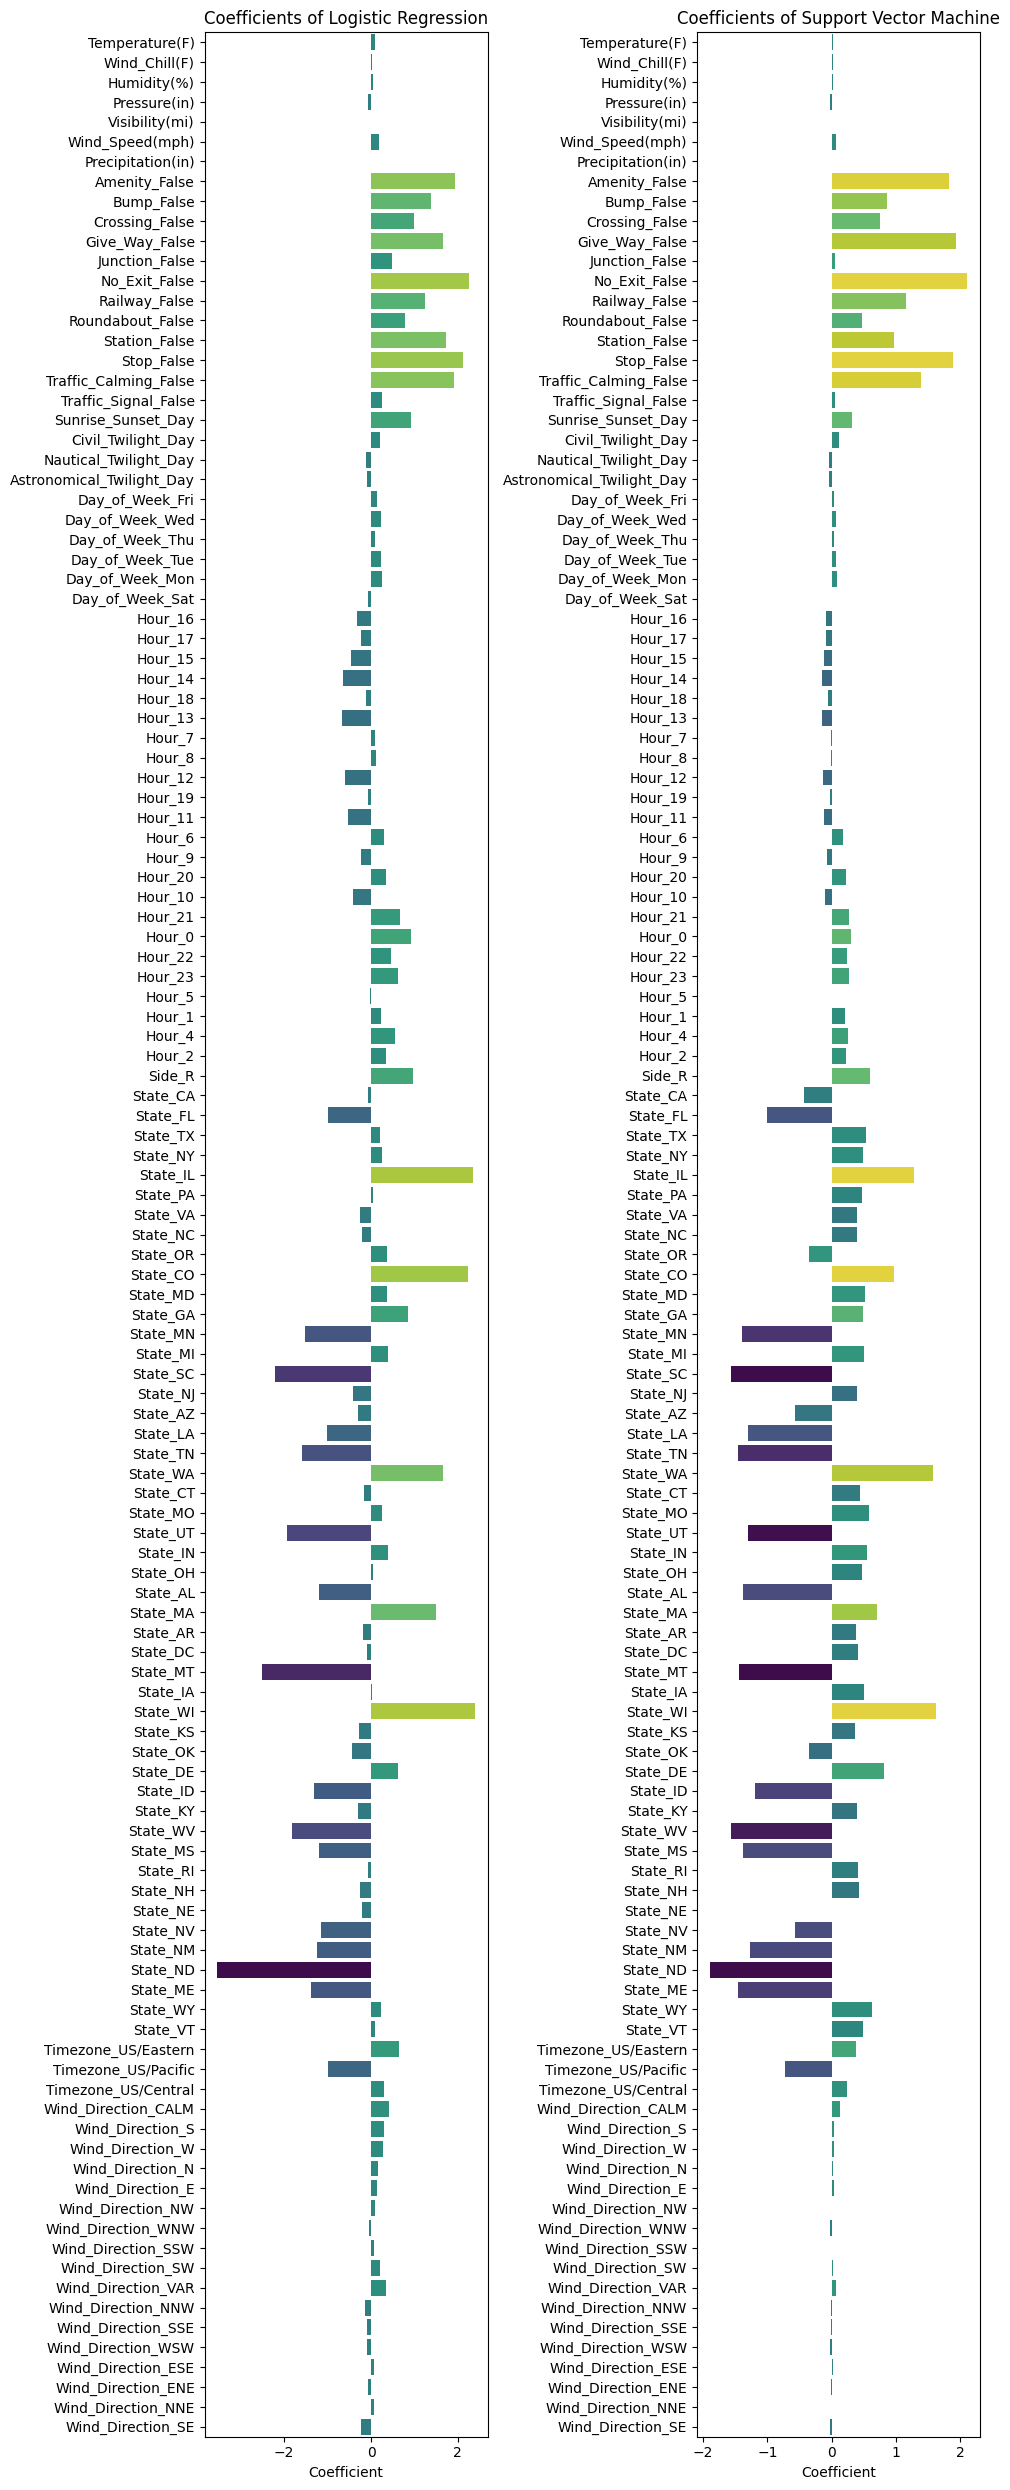

In [47]:
from matplotlib import cm

fig, axes = plt.subplots(1,2, figsize = (10,25))

lr_coefficients = list(zip(features_list, lr_model.bestModel.stages[-1].coefficients))
lr_norm = plt.Normalize(-3, 3)
lr_colors = cm.viridis(lr_norm(lr_model.bestModel.stages[-1].coefficients))
lr_coefficients_pd = pd.DataFrame(lr_coefficients, columns=['Feature', 'Coefficient'])
lr_barplot = sns.barplot(x='Coefficient', y='Feature', data = lr_coefficients_pd, ax = axes[0], palette = lr_colors)
lr_barplot.set_ylabel('')
axes[0].set_title('Coefficients of Logistic Regression')

lsvc_coefficients = list(zip(features_list, lsvc_model.bestModel.stages[-1].coefficients))
lsvc_norm = plt.Normalize(-2, 2)
lsvc_colors = cm.viridis(lsvc_norm(lr_model.bestModel.stages[-1].coefficients))
lsvc_coefficients_pd = pd.DataFrame(lsvc_coefficients, columns=['Feature', 'Coefficient'])
lsvc_barplot = sns.barplot(x='Coefficient', y='Feature', data = lsvc_coefficients_pd, ax = axes[1], palette = lsvc_colors)
lsvc_barplot.set_ylabel('')
axes[1].set_title('Coefficients of Support Vector Machine')

plt.tight_layout()
plt.show()

We can confirm that the signs of the coefficients are generally consistent between the two models.

**Feature Importances: Random Forest & Gradient Boosting**

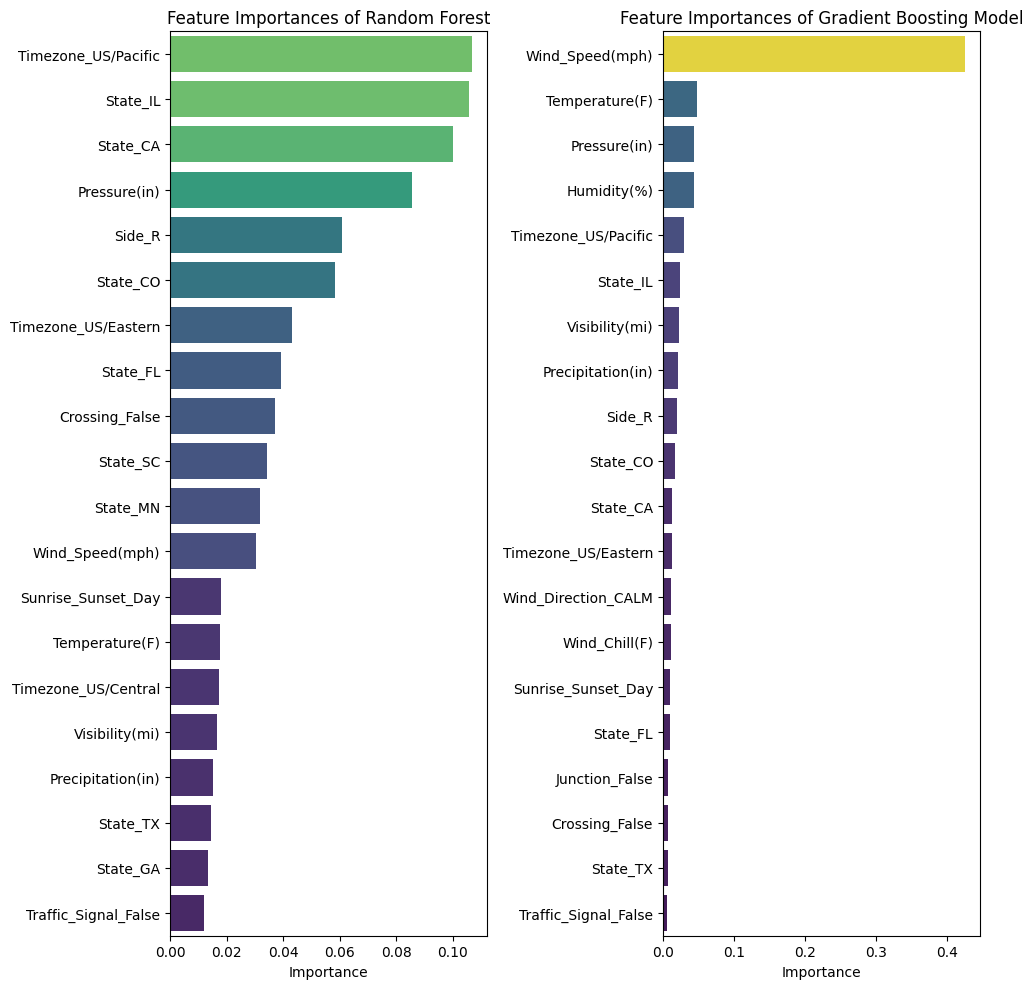

In [50]:
warnings.filterwarnings('ignore')

fig, axes = plt.subplots(1,2, figsize = (10,10))

rf_importances = list(zip(features_list, rf_bestModel.featureImportances))
sorted_rf_importances = sorted(rf_importances, key=lambda x: x[1], reverse=True)[:20]
sorted_rf_importances_pd = pd.DataFrame(sorted_rf_importances, columns=['Feature', 'Importance'])
rf_norm = plt.Normalize(0, 0.14)
rf_colors = cm.viridis(rf_norm(sorted_rf_importances_pd['Importance']))
rf_barplot = sns.barplot(x='Importance', y='Feature', data = sorted_rf_importances_pd, ax = axes[0], legend=False, palette = rf_colors)
rf_barplot.set_title('Feature Importances of Random Forest')
rf_barplot.set_ylabel('')


gbt_importances = list(zip(features_list, gbt_bestModel.featureImportances))
sorted_gbt_importances = sorted(gbt_importances, key=lambda x: x[1], reverse=True)[:20]
sorted_gbt_importances_pd = pd.DataFrame(sorted_gbt_importances, columns=['Feature', 'Importance'])
gbt_norm = plt.Normalize(0, 0.14)
gbt_colors = cm.viridis(gbf_norm(sorted_gbt_importances_pd['Importance']))
gbt_barplot = sns.barplot(x='Importance', y='Feature', data = sorted_gbt_importances_pd, ax = axes[1], legend=False, palette = gbt_colors)
gbt_barplot.set_title('Feature Importances of Gradient Boosting Model')
gbt_barplot.set_ylabel('')

plt.tight_layout()
plt.show()

We can verify that time zone and state features are more important in random forest while weather related features are more important in gradient boosting when predicting the severity of car accidents.